In [11]:
# if you want to use omicverse in windows please remember install annoy with https://anaconda.org/conda-forge/python-annoy
import omicverse as ov
import scanpy as sc
import scvelo as scv

ov.utils.ov_plot_set()

All dependencies are satisfied.


In [12]:
adata = sc.read_h5ad("./ctr-4h-0/binned_outputs_square_008um.h5ad")
adata.obs["annotation"]= sc.read_h5ad("./Integrate/adata_CTR_napari_gpnmb.h5ad").obs["annotation"]
adata

AnnData object with n_obs × n_vars = 155282 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

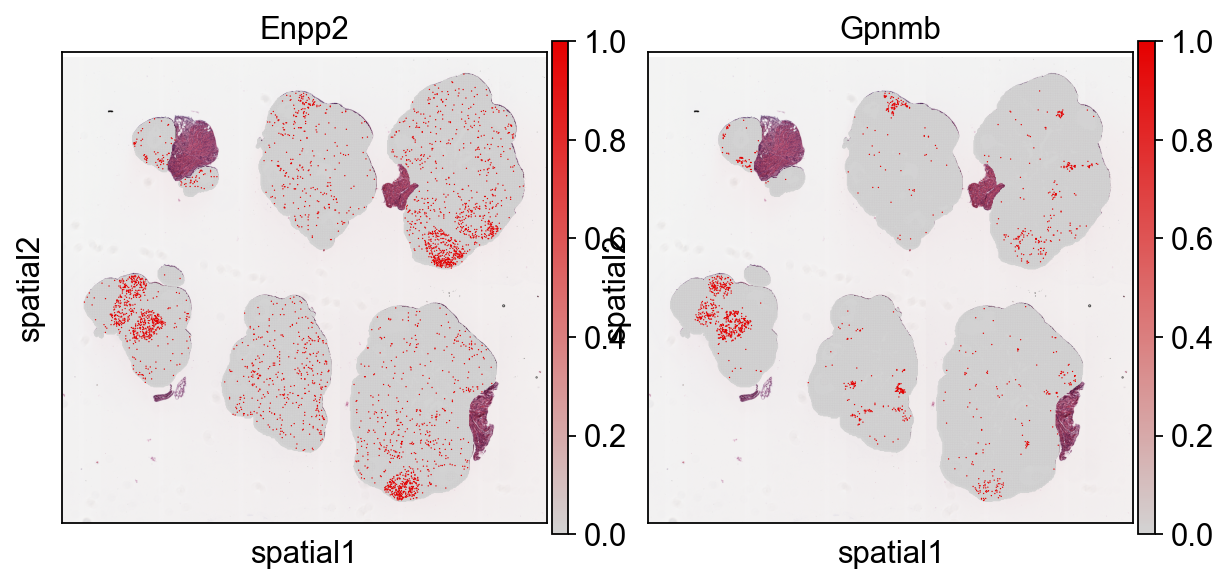

In [13]:
import seaborn as sns
sc.pl.spatial(adata, color = ["Enpp2", "Gpnmb"], 
              cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["red"]], as_cmap=True), 
              spot_size=30, 
              ncols=2, wspace=0.1, vmin=0, vmax='p99.2')

In [14]:
# we need the log data
adata.X.max()

253.0

In [15]:
adata_antral=adata[~adata.obs['annotation'].isin(['unassigned'])]
adata_antral.obs.annotation.value_counts()

annotation
Antral_gpnmb_minus    58236
Antral_gpnmb_plus     11538
Name: count, dtype: int64

In [16]:
sc.pp.filter_cells(adata_antral, min_counts=100)
sc.pp.filter_genes(adata_antral, min_cells=3)
print(adata_antral)

filtered out 2388 cells that have less than 100 counts
filtered out 97 genes that are detected in less than 3 cells
AnnData object with n_obs × n_vars = 69774 × 18962
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'


In [17]:
sc.pp.calculate_qc_metrics(
    adata_antral,  inplace=True
)

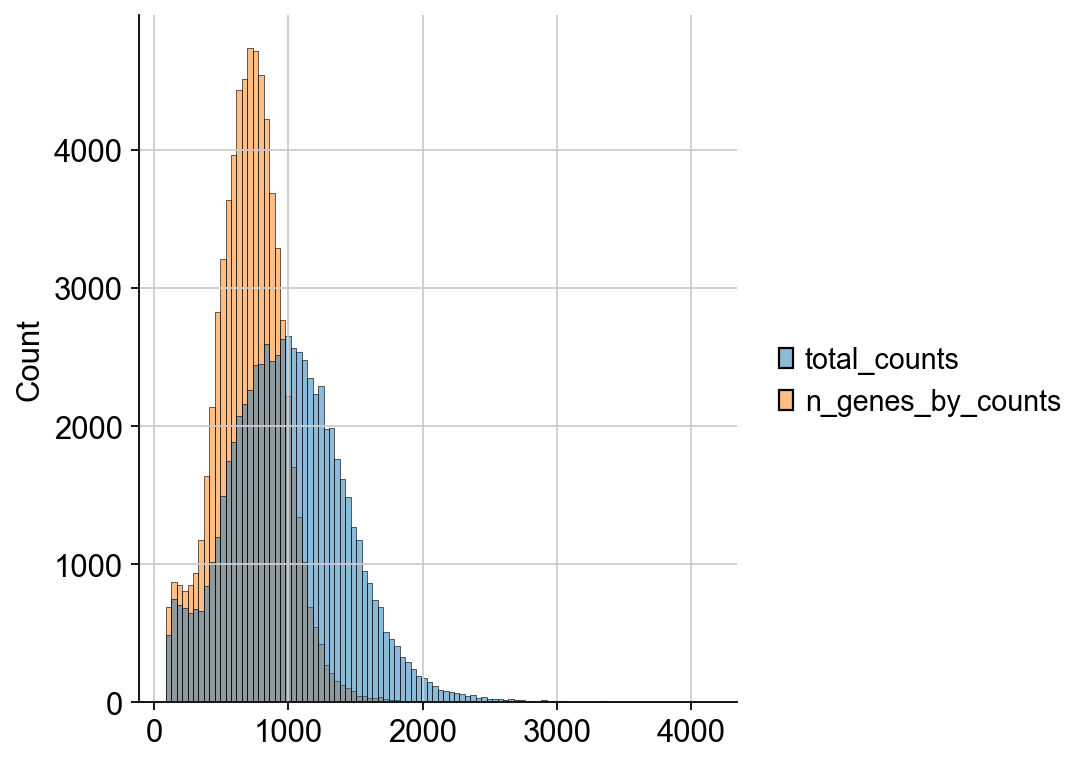

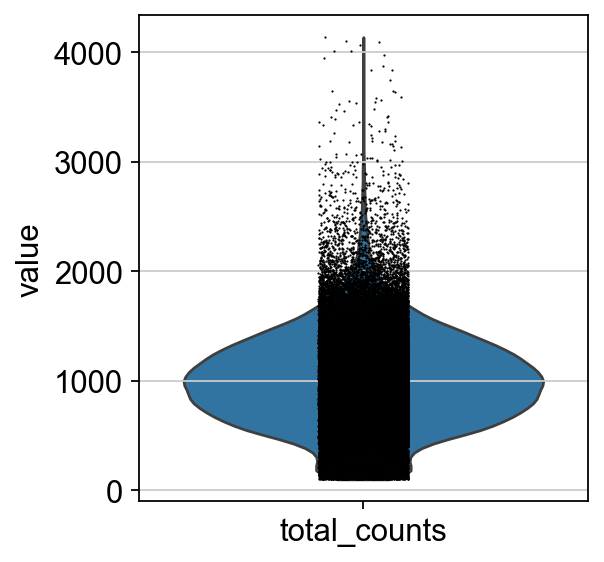

In [18]:
import seaborn as sns
sns.displot(adata_antral.obs[["total_counts","n_genes_by_counts"]], bins=100, kde=False)
sc.pl.violin(adata_antral, 'total_counts')

In [19]:
adata_antral.var_names_make_unique()
print(adata_antral)

AnnData object with n_obs × n_vars = 69774 × 18962
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'


In [20]:
#存储原始数据以便后续还原
adata_antral.layers['counts']=adata_antral.X.copy()

sc.pp.normalize_total(adata_antral)
sc.pp.log1p(adata_antral)
adata_antral.layers['log1p']=adata_antral.X.copy()
adata_antral

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 69774 × 18962
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'
    layers: 'counts', 'log1p'

In [21]:
# #normalize and high variable genes (HVGs) calculated
# adata_antral=ov.pp.preprocess(adata_antral,mode='shiftlog|pearson',n_HVGs=5000,)

# #save the whole genes and filter the non-HVGs
# adata_antral.raw = adata_antral
# adata_antral = adata_antral[:, adata_antral.var.highly_variable_features]

In [22]:
adata_antral.X.max()

4.891179

In [23]:
adata_antral.write_h5ad("Integrate/adata_antral_gpnmb_to_r.h5ad")

In [14]:
dds=ov.bulk.pyDEG(adata_antral.to_df(layer='log1p').T)
dds.drop_duplicates_index()
print('... drop_duplicates_index success')

... drop_duplicates_index success


In [15]:
treatment_groups=adata_antral.obs[adata_antral.obs['annotation']=='Antral_gpnmb_plus'].index.tolist()
control_groups=adata_antral.obs[adata_antral.obs['annotation']=='Antral_gpnmb_minus'].index.tolist()
df = dds.deg_analysis(treatment_groups,control_groups,method='ttest')

In [16]:
# 查找基因为 'Gpnmb' 或 'Enpp2' 的行
result = df[df.index.isin(['Gpnmb', 'Enpp2'])]

# 显示结果
result

,pvalue,qvalue,FoldChange,MaxBaseMean,BaseMean,log2(BaseMean),log2FC,abs(log2FC),size,-log(pvalue),-log(qvalue),sig
Enpp2,0.0,0.0,12.391573,0.781183,0.421217,-1.247364,3.631287,3.631287,1.239157,inf,inf,sig
Gpnmb,0.0,0.0,37.586002,0.380968,0.194604,-2.361384,5.232123,5.232123,3.758600,inf,inf,sig


In [17]:
df.to_csv("./csv/deg_gpnmb_antral.csv")

In [125]:
dds.foldchange_set(fc_threshold=-3.6,
                   pval_threshold=0.0000000000005,
                   logp_max=100)

... Fold change threshold: -3.6


<AxesSubplot: title={'center': 'DEG Analysis'}, xlabel='$log_{2}FC$', ylabel='$-log_{10}(qvalue)$'>

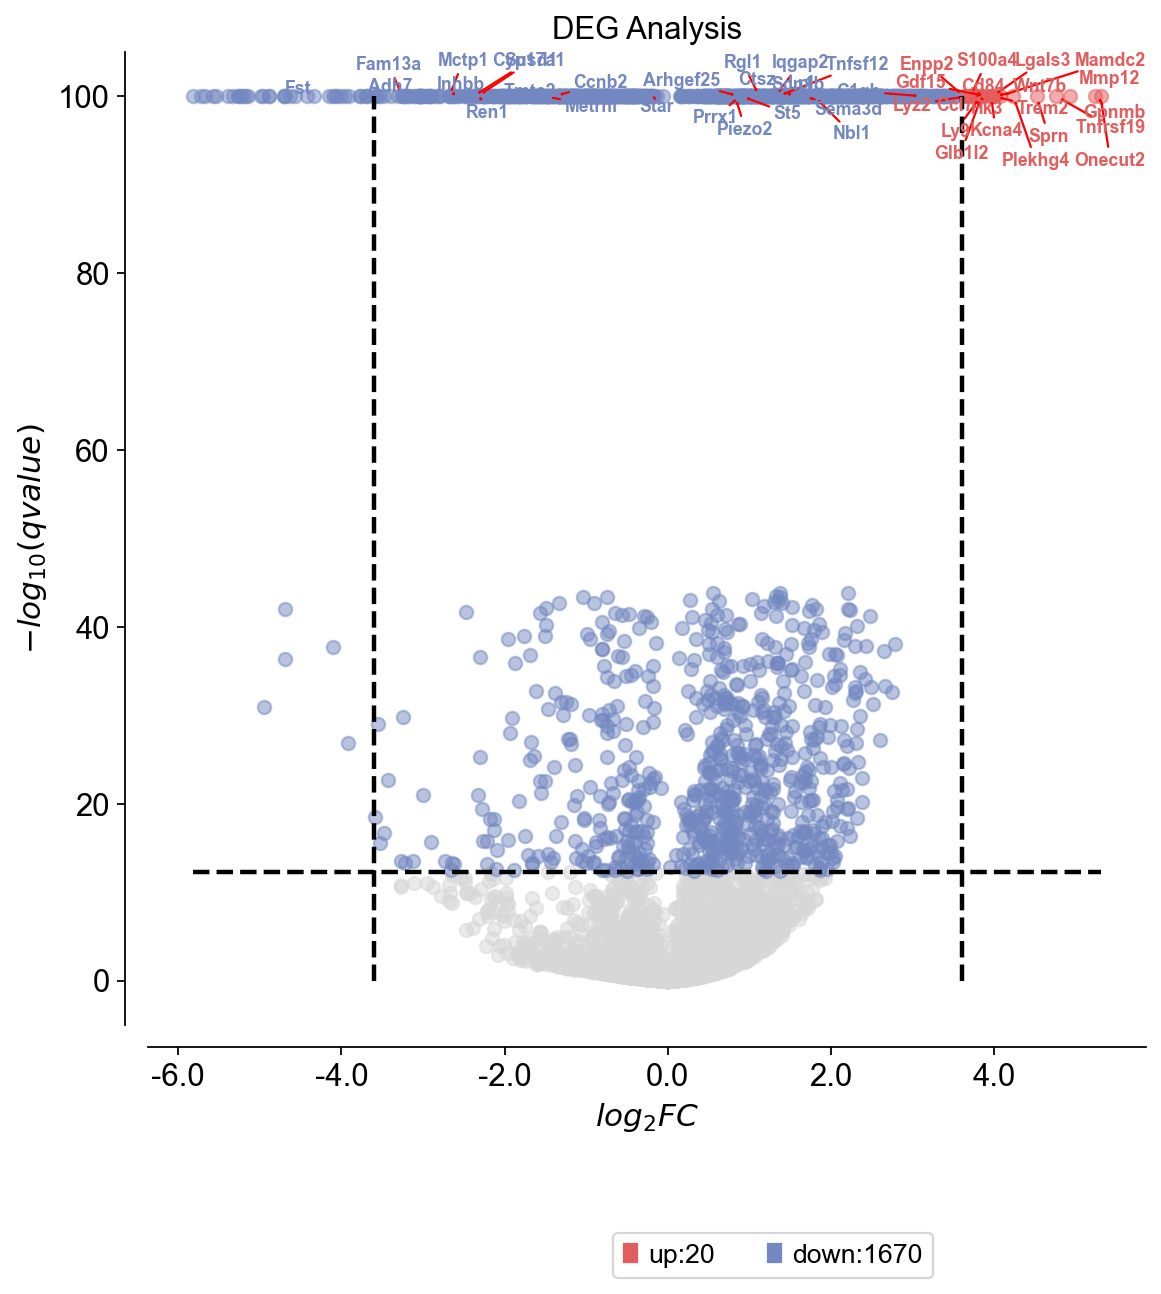

In [129]:
dds.plot_volcano(title='DEG Analysis',figsize=(8,8),
                 plot_genes_num=50,plot_genes_fontsize=8,)

(<Figure size 160x240 with 1 Axes>,
 <AxesSubplot: title={'center': 'Gene Expression'}>)

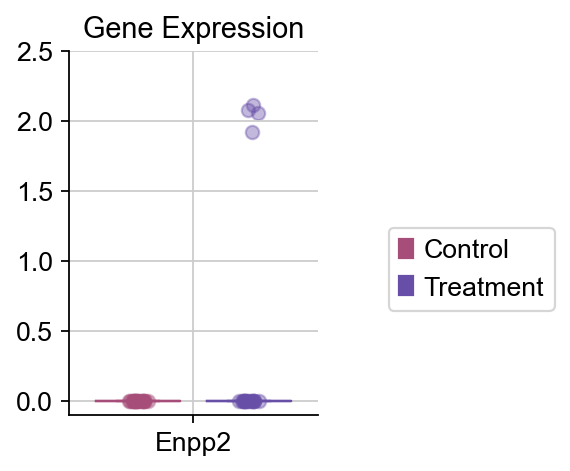

In [56]:
dds.plot_boxplot(genes=['Enpp2'],treatment_groups=treatment_groups,
                control_groups=control_groups,figsize=(2,3),fontsize=12,
                 legend_bbox=(2,0.55))

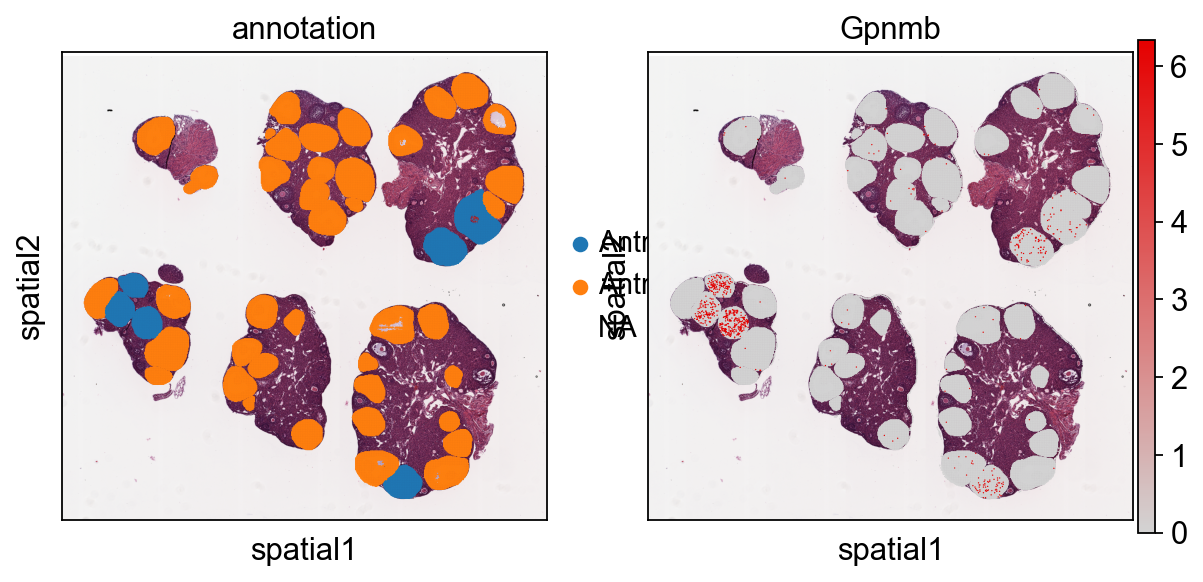

In [58]:
import seaborn as sns
sc.pl.spatial(adata_antral, color = ["annotation", "Gpnmb"], 
              cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["red"]], as_cmap=True), 
              spot_size=30, 
              ncols=2, wspace=0.1, vmin=0, vmax='p99.2')

In [59]:
adata_antral.write_h5ad("Integrate/CTR_gpnmb_follicle.h5ad")

In [10]:
adata_antral = sc.read_h5ad("Integrate/CTR_gpnmb_follicle.h5ad")

In [60]:
pathway_dict=ov.utils.geneset_prepare('genesets/GO_Biological_Process_2021.txt',organism='Mouse')

In [12]:
adata_antral=adata[~adata.obs['annotation'].isin(['unassigned'])]
adata_antral.obs.annotation.value_counts()

annotation
Antral_gpnmb_minus    58236
Antral_gpnmb_plus     11538
Name: count, dtype: int64

In [62]:
adata_aucs.obs=adata_antral[adata_aucs.obs.index].obs
adata_aucs.obsm=adata_antral[adata_aucs.obs.index].obsm
adata_aucs.obsp=adata_antral[adata_aucs.obs.index].obsp
adata_aucs

AnnData object with n_obs × n_vars = 72162 × 6036
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation'
    obsm: 'spatial'

In [63]:
adata_aucs.write_h5ad('pyobjs/gpnmb_antral_auc.h5ad',compression='gzip')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


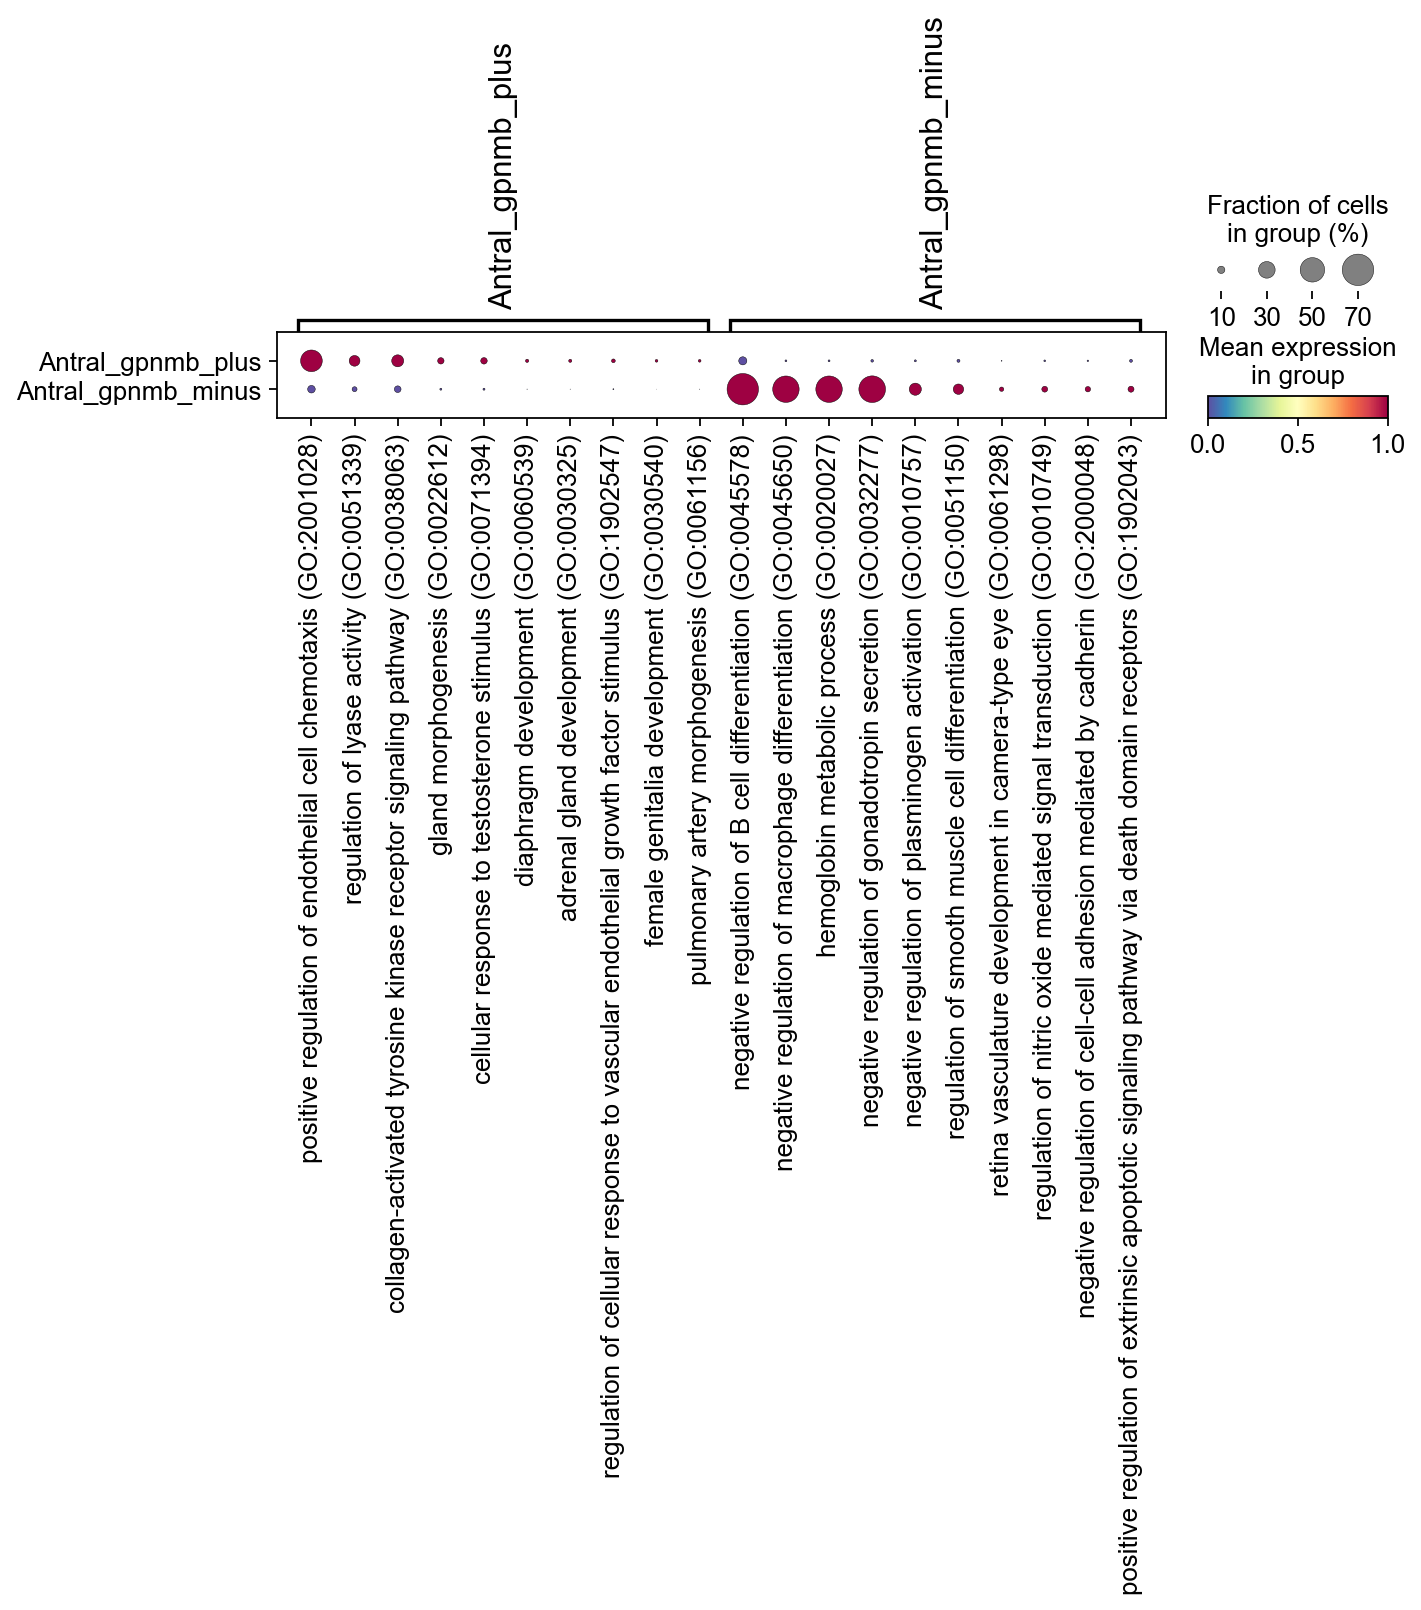

In [69]:
adata_aucs = sc.read_h5ad('pyobjs/gpnmb_antral_auc.h5ad')
#adata_aucs.uns['log1p']['base']=None
sc.tl.rank_genes_groups(adata_aucs, 'annotation', method='t-test',n_genes=100)
sc.pl.rank_genes_groups_dotplot(adata_aucs,groupby='annotation',
                                cmap='Spectral_r',
                                standard_scale='var',n_genes=10,)

In [103]:
adata_antral=adata[~adata.obs['annotation'].isin(['unassigned'])]
# 将列转换为字符串类型
adata_antral.obs['annotation'] = adata_antral.obs['annotation'].astype(str)
adata_antral.obs.annotation.value_counts()

annotation
Antral_gpnmb_minus    58236
Antral_gpnmb_plus     11538
nan                    2388
Name: count, dtype: int64

In [104]:
adata_antral = adata_antral[~adata_antral.obs.annotation.isin(["nan"])]
adata_antral.obs['annotation'] = adata_antral.obs['annotation'].astype("category")
adata_antral.obs.annotation.value_counts()

annotation
Antral_gpnmb_minus    58236
Antral_gpnmb_plus     11538
Name: count, dtype: int64

In [105]:
#normalize and high variable genes (HVGs) calculated
adata_antral=ov.pp.preprocess(adata_antral,mode='shiftlog|pearson',n_HVGs=5000,)

#save the whole genes and filter the non-HVGs
adata_antral.raw = adata_antral
adata_antral = adata_antral[:, adata_antral.var.highly_variable_features]

Begin robust gene identification
After filtration, 19011/19059 genes are kept.     Among 19011 genes, 15530 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 7.493678331375122 seconds.
End of size normalization: shiftlog and HVGs selection pearson


In [106]:
# adata_aucs_before.uns['lognorm']['base']=None
sc.tl.rank_genes_groups(adata_antral, 'annotation', method='t-test',n_genes=3000)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


2024-09-15 23:11:26,563 Downloading mmusculus_gene_ensembl for the first time. It might take a couple of miniutes.
2024-09-15 23:13:48,884 Downloading mmusculus_gene_ensembl for the first time. It might take a couple of miniutes.


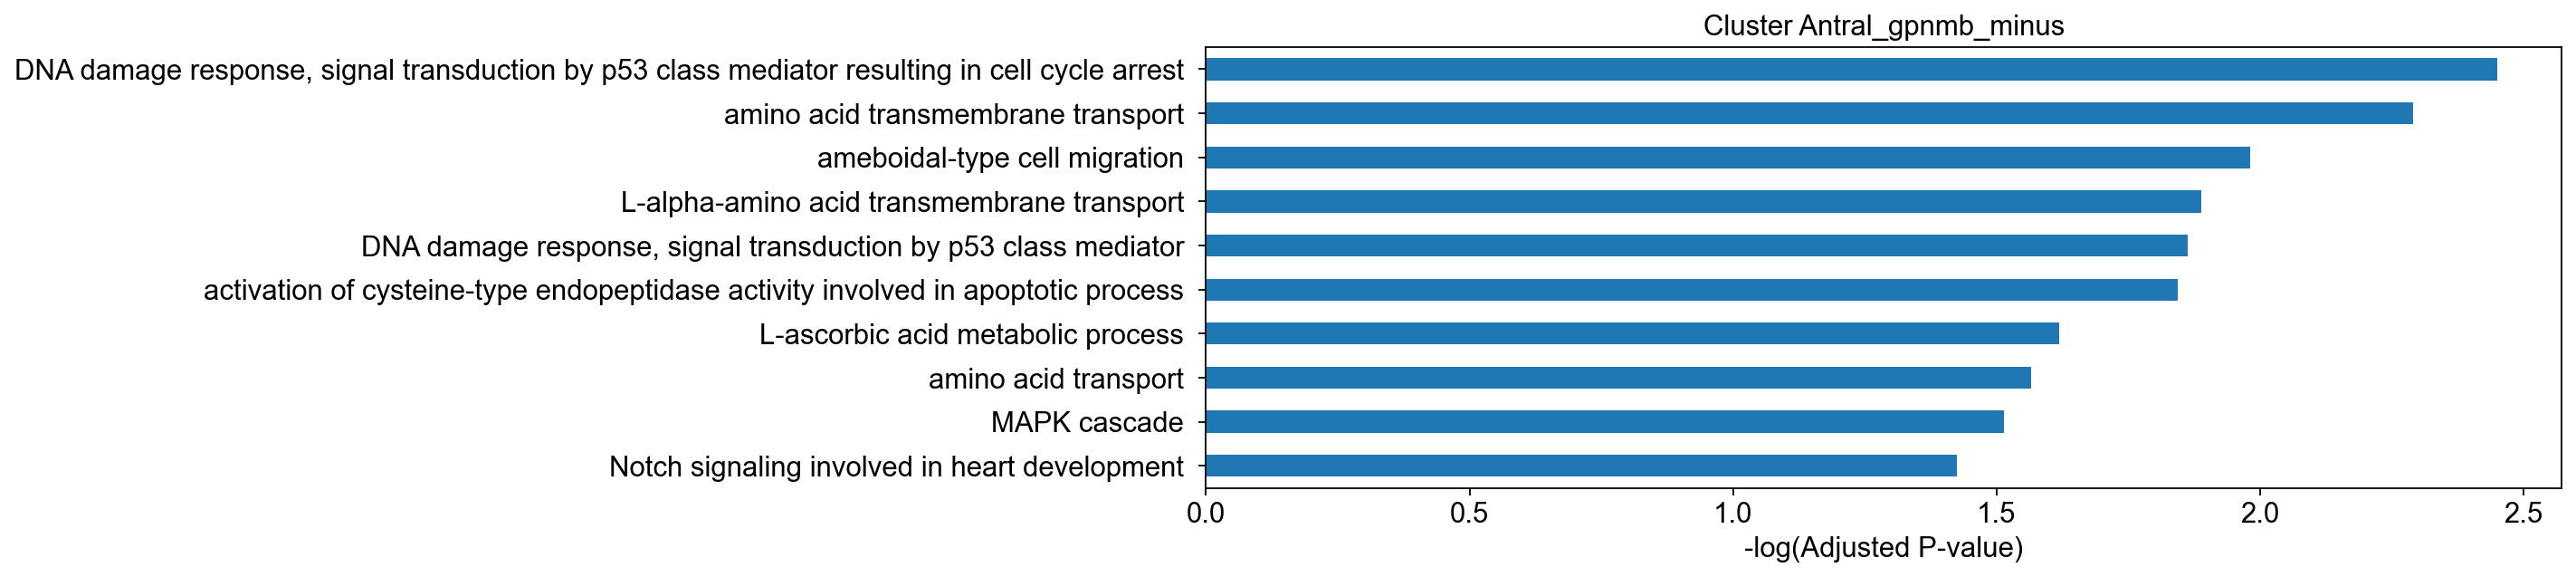

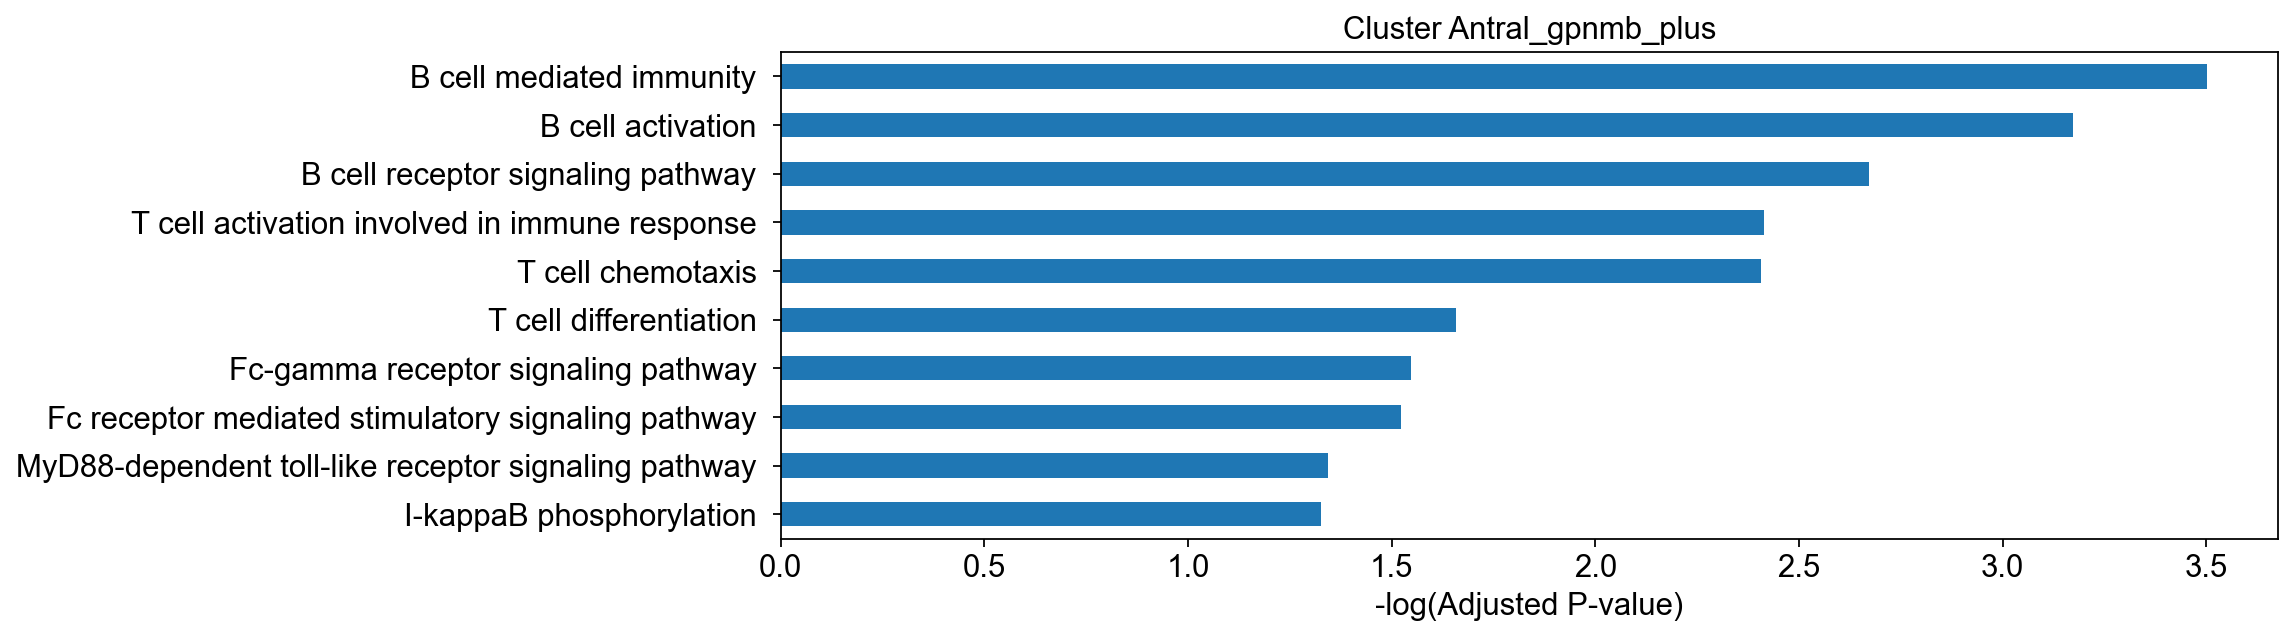

In [107]:
# 修正并调用 pathway_enrichment 函数
res = ov.single.pathway_enrichment(
    adata_antral,
    pathways_dict=pathway_dict,
    organism='Mouse',
    group_by='annotation',  # 确保这一列的数据类型一致
    plot=True
)


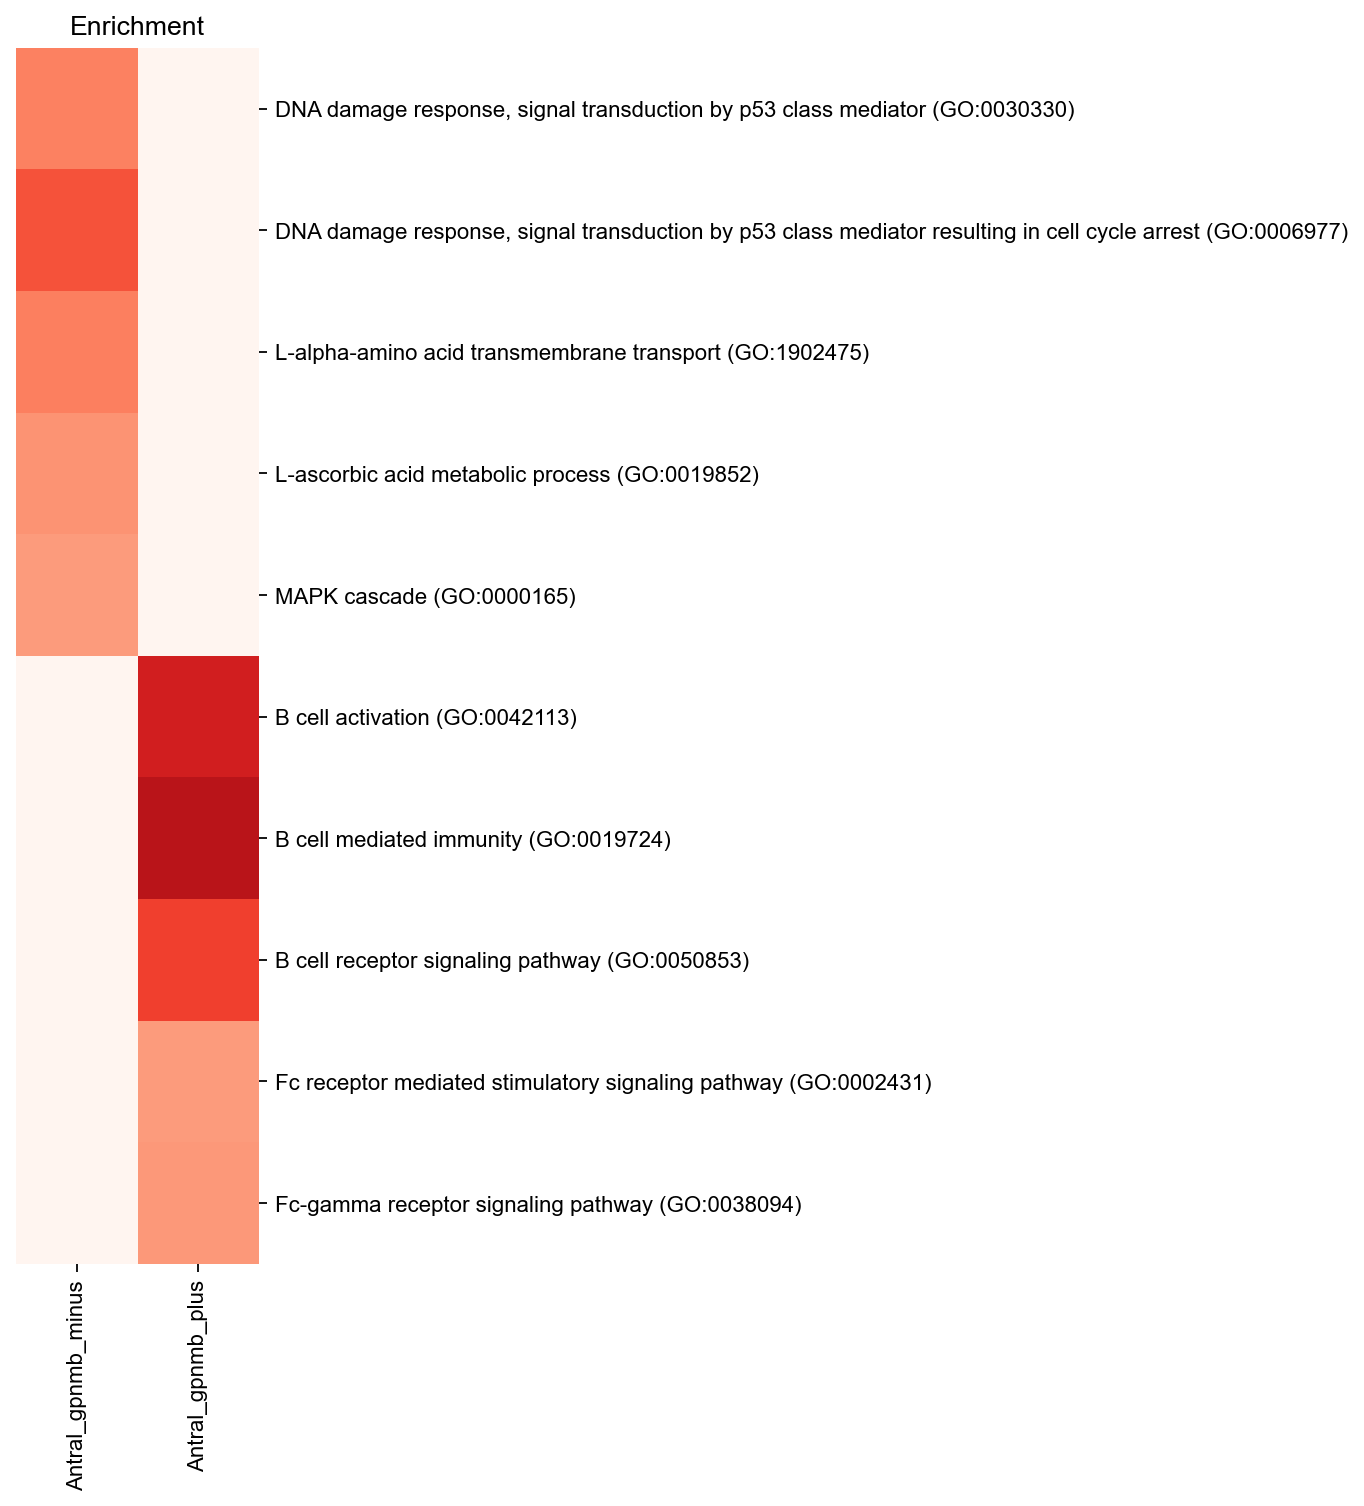

In [108]:
ax=ov.single.pathway_enrichment_plot(res,plot_title='Enrichment',cmap='Reds',
                                         xticklabels=True,cbar=False,square=True,vmax=10,
                                         yticklabels=True,cbar_kws={'label': '-log10(qvalue)','shrink': 0.5,})

In [109]:
import pandas as pd
res.to_csv("csv/enrichment_gpnmb_an.csv", index=False)

In [110]:
# 进行差异表达分析
sc.tl.rank_genes_groups(adata_antral, groupby='annotation', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:51)


In [111]:
# 查看结果，得到p值
result = adata_antral.uns['rank_genes_groups']
groups = result['names'].dtype.names

# 打印每个对比组的前3个基因
for group in groups:
    print(f"Group {group}:")
    print("Gene names:", result['names'][group][:3])
    print("P-values:", result['pvals'][group][:3])

Group Antral_gpnmb_minus:
Gene names: ['Inha' 'Acly' 'Fdx1']
P-values: [0. 0. 0.]
Group Antral_gpnmb_plus:
Gene names: ['Col3a1' 'Clu' 'Pdia4']
P-values: [0. 0. 0.]


In [113]:
import pandas as pd
# 提取差异表达数据
def get_rank_genes_groups_df(adata, group):
    result = adata.uns['rank_genes_groups']
    return pd.DataFrame({
        'names': result['names'][group],
        'pvals': result['pvals'][group],
        'logfoldchanges': result['logfoldchanges'][group]
    })
    # 获取特定对比组的DataFrame

df = get_rank_genes_groups_df(adata_antral, "Antral_gpnmb_plus")

In [114]:

# 查找基因为 'Gpnmb' 或 'Enpp2' 的行
result = df[df['names'].isin(['Gpnmb', 'Enpp2'])]

# 显示结果
print(result)

     names         pvals  logfoldchanges
93   Enpp2  7.974764e-77        4.234791
228  Gpnmb  4.035763e-21        5.812189


In [13]:
adata_antral.obs.annotation.value_counts()

annotation
Antral_gpnmb_minus    58236
Antral_gpnmb_plus     11538
Name: count, dtype: int64

In [7]:
adata_antral

AnnData object with n_obs × n_vars = 72162 × 5000
    obs: 'in_tissue', 'array_row', 'array_col', 'annotation'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'annotation_colors', 'hvg', 'log1p', 'spatial', 'batch_colors'
    obsm: 'spatial'
    layers: 'counts', 'lognorm'

In [5]:
# 添加颜色信息到adata.uns中
adata_antral.uns['annotation_colors'] = ['#DFDFDF','#F29A9D']

In [6]:
adata_antral.uns['batch_colors'] = ['#DFDFDF','#F29A9D']

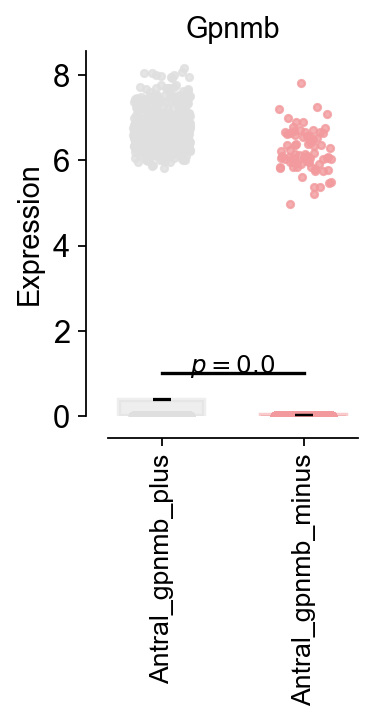

In [21]:
import matplotlib.pyplot as plt
# 需要改成CTR是灰色#DFDFDF，AAV组是粉红色#F29A9D
fig, ax = plt.subplots(figsize=(2,3))
ov.pl.bardotplot(adata_antral,groupby='annotation',color='Gpnmb',figsize=(2,2),
           ax=ax,
          ylabel='Expression',
           bar_kwargs={'alpha':0.5,'linewidth':2,'width':0.6,'capsize':4},
           scatter_kwargs={'alpha':0.8,'s':10,'marker':'o'})

ov.pl.add_palue(ax,line_x1=0,line_x2=1,line_y=1,
          text_y=0.02,
          text='$p={}$'.format(round(0.0001,3)),
          fontsize=11,fontcolor='#000000',
             horizontalalignment='center',)

图表已保存为 figures/enpp2.pdf


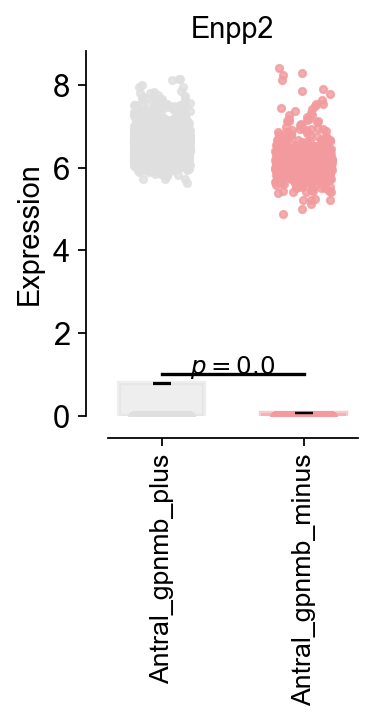

In [34]:
import matplotlib.pyplot as plt
# 需要改成CTR是灰色#DFDFDF，AAV组是粉红色#F29A9D
fig, ax = plt.subplots(figsize=(2,3))
ov.pl.bardotplot(adata_antral,groupby='annotation',color='Enpp2',figsize=(2,2),
           ax=ax,
          ylabel='Expression',
           bar_kwargs={'alpha':0.5,'linewidth':2,'width':0.6,'capsize':4},
           scatter_kwargs={'alpha':0.8,'s':10,'marker':'o'})

ov.pl.add_palue(ax,line_x1=0,line_x2=1,line_y=1,
          text_y=0.02,
          text='$p={}$'.format(round(0.0000001,5)),
          fontsize=11,fontcolor='#000000',
             horizontalalignment='center')

# 保存图表为 PDF 文件
pdf_file_path = 'figures/enpp2.pdf'
plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight')
print(f'图表已保存为 {pdf_file_path}')

# 显示图表
plt.show()

AttributeError: 'AnnData' object has no attribute 'groupby'

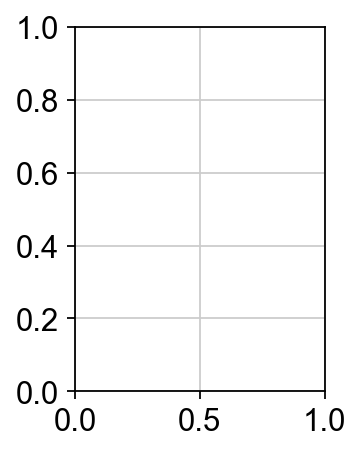

In [30]:
# 绘制柱状图
fig, ax = plt.subplots(figsize=(2, 3))

for name, group in grouped_data:
    ax.bar(name, group['Enpp2'].mean(), color=colors[name], alpha=0.5, linewidth=2, width=0.6, capsize=4)
    ax.scatter([name]*len(group), group['Enpp2'], color=colors[name], alpha=0.8, s=10, marker='o')

ax.set_ylabel('Expression')

# 添加 p-value 线条和注释
line_x1, line_x2, line_y = 0, 1, 1
ax.plot([line_x1, line_x2], [line_y, line_y], color='black')
ax.text((line_x1 + line_x2) / 2, line_y + 0.02, '$p={}$'.format(round(0.0000001, 5)), fontsize=11, color='#000000', horizontalalignment='center')

# 保存图表为 PDF 文件
pdf_file_path = '示例图表.pdf'
plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight')
print(f'图表已保存为 {pdf_file_path}')

# 显示图表
plt.show()